In [1]:
%matplotlib inline
import quest
import numpy as np 
from matplotlib import colors, cm, pyplot as plt
from gazar import grid

In [2]:
VICKSBURG = 'vicksburg'
PROVO = 'provo'

location = PROVO
# location = VICKSBURG

SERVICE = 'svc://usgs-ned:13-arc-second'

BBOXES = {VICKSBURG: [-90.9, 32.2, -90.8, 32.3],
          PROVO: [-111.6, 40.0, -111.4, 40.15]
         }

OUTLETS = {VICKSBURG: (-90.885, 32.2158), # (-90.889, 32.2133) Move point out of Mississippi River,
           PROVO: (-111.44851851851851, 40.0787962962963),
          }

#service_feature = SERVICE_FEATURES[location]
bbox = BBOXES[location]
outlet_point = [OUTLETS[location]]

In [3]:
choice = input('Reuse existing downloads (y/n):')

Reuse existing downloads (y/n):y


In [4]:
# Delete all collections
# for collection in quest.api.get_collections():
#   quest.api.delete(collection)

In [5]:
# create new collection
# Avoid re-downloading elevation data if already present 
collection = 'watershed_delineation_' + location
if choice.lower()=='n':
    if collection in quest.api.get_collections():
        quest.api.delete(collection)

In [6]:
elev_name = 'merged elevation raster ' + location
elevation = quest.api.get_datasets(filters={'display_name': elev_name})
print(elevation)

if not elevation:
    try:
        quest.api.new_collection(collection)
    except ValueError:
        quest.api.delete(collection)
        quest.api.new_collection(collection)

    # download elevation data
    elevation_tiles = quest.api.get_features('svc://usgs-ned:13-arc-second', filters={'bbox': bbox})
    print('Selected tiles:', elevation_tiles)
    elevation_tiles = quest.api.add_features(collection, elevation_tiles)
    datasets = quest.api.stage_for_download(elevation_tiles)
    print('start download -->')
    quest.api.download_datasets(datasets)
    print('start merge -->')
    result = quest.api.apply_filter('raster-merge', datasets=datasets, options={'bbox': bbox}, display_name=elev_name)
    elevation = result['datasets'][0]
    print('merged elevation tile:', elevation)

['d990030f468a409a8a87b154a3c222f4']


In [7]:
# run pit filling algorithm
algorithm = 'go-fill'  # one of ['flats', 'go-fill', 'go-breach']
result = quest.api.apply_filter('raster-fill', datasets=elevation, options={'algorithm': algorithm})
pit_filled = result['datasets'][0]

Setting up go-spatial tool: FillDepressions
Running process...
Done!


In [8]:
# run flow accumulation
algorithm = 'go-d8'  # one of ['d8', 'go-d8', 'go-fd8']
result = quest.api.apply_filter('raster-flow-accumulation', datasets=pit_filled, options={'algorithm': algorithm})
flow_accumulation_dataset_id = result['datasets'][0]

Setting up go-spatial tool: D8FlowAccumulation
Running process...
Done!


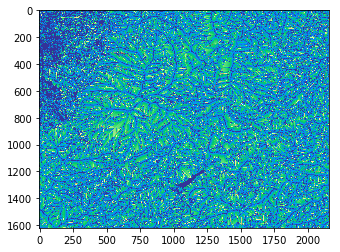

In [9]:
# read & plot in flow accumulation
flow_accumulation_dataset_file = quest.api.get_metadata(flow_accumulation_dataset_id)[flow_accumulation_dataset_id]['file_path']
flow_accumulation_dataset = grid.GDALGrid(flow_accumulation_dataset_file)
flow_accumulation_data = flow_accumulation_dataset.np_array()
plt.imshow(flow_accumulation_data, cmap=cm.terrain, norm=colors.LogNorm())

outlet points snapped, new feature created: [(-111.44851851851853, 40.078796296296296)] f23c3972b8344ec882fabcf7870a6c21
0.001890711817937191


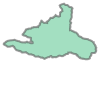

In [10]:
result = quest.api.apply_filter('raster-watershed-delineation', datasets=pit_filled, 
                       options={'outlet_points': outlet_point, 'snap_outlets': 'jenson', 'stream_threshold_pct': 0.01})
watershed = result['features']['watershed']
outlet = result['features']['outlet']
watershed_geometry = quest.api.get_metadata(watershed)[watershed]['geometry']
outlet_lon, outlet_lat = np.array(quest.api.get_metadata(outlet)[outlet]['geometry'].coords.xy).squeeze().tolist()
print(watershed_geometry.area)
watershed_geometry

In [12]:
# read in elevation data
dem_file = quest.api.get_metadata(elevation[0])[elevation[0]]['file_path']
dem = grid.GDALGrid(dem_file)
lat, lon = dem.latlon

(569, 969)

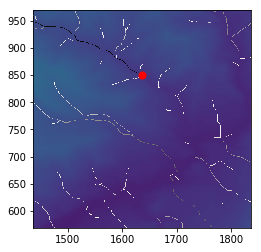

In [13]:
# plot outlet pixel and river network
window = 200
stream_threshold = flow_accumulation_data.max() * 0.01
rivers = np.ma.masked_where(flow_accumulation_data < stream_threshold, flow_accumulation_data)
fig, ax = plt.subplots()
ax.imshow(np.flip(dem.np_array(), 0))
plt.imshow(np.flip(rivers, 0), cmap=cm.gray_r, norm=colors.LogNorm(), origin="lower")
outlet_col, outlet_row = flow_accumulation_dataset.lonlat2pixel(outlet_lon, outlet_lat)
ax.scatter(x=outlet_col, y=rivers.shape[0] - outlet_row, s=50, color='red')
ax.set_xlim((outlet_col-window,outlet_col+window))
ax.set_ylim((outlet_row-window,outlet_row+window))

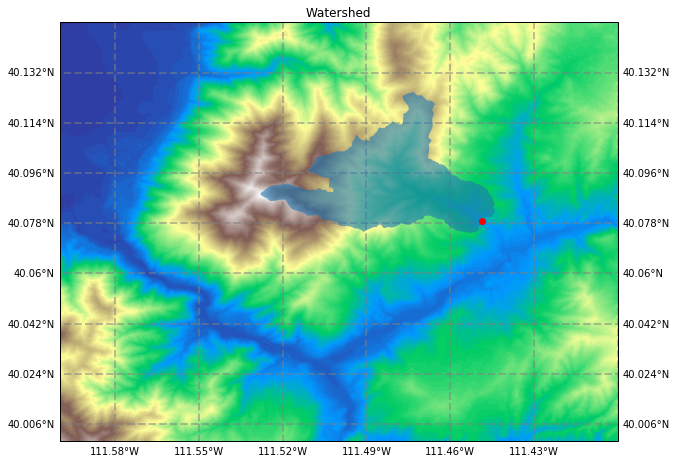

In [14]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

xmin, ymin, xmax, ymax = bbox
display_bbox = [xmin, xmax, ymin, ymax]
graticule_spacing = 0.01

fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent(display_bbox)

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabels_top = False

plt.contourf(lon, lat, dem.np_array(), 100, zorder=2, cmap=cm.terrain, transform=ccrs.PlateCarree())
ax.imshow(rivers, cmap=cm.ocean, origin='lower', zorder=3)
watershed_shp = cfeature.ShapelyFeature([watershed_geometry], ccrs.PlateCarree())
ax.add_feature(watershed_shp, zorder=4, alpha=0.6)
ax.scatter(x=outlet_lon, y=outlet_lat, color='red', zorder=5, transform=ccrs.PlateCarree())
ax.scatter(x=-90.885, y=32.2158, color='blue', zorder=5, transform=ccrs.PlateCarree())
plt.title("Watershed")
plt.show()